In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm

In [2]:
TRAIN_DIR = "./train"
TEST_DIR = "./test"
IMG_SIZE = 50
LR = 0.001

In [3]:
MODEL_NAME = "catdog-{}-{}.model".format(LR, "2conv-basic")

In [4]:
def convert_to_one_hot_label(img_name):
    label = img_name.split(".")[0]
    return [1, 0] if label == "cat" else [0, 1]

In [5]:
assert convert_to_one_hot_label("cat.1234.jpg") == [1, 0]
assert convert_to_one_hot_label("dog.1234.jpg") == [0, 1]

In [6]:
def create_train_data():
    train_data = []
    for img_name in tqdm(os.listdir(TRAIN_DIR)):
        one_hot_label = convert_to_one_hot_label(img_name)
        path = os.path.join(TRAIN_DIR, img_name)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        train_data.append([img, np.array(one_hot_label)])
    np.random.shuffle(train_data)
    np.save("train_data.npy", train_data)
    return train_data

In [7]:
def create_test_data():
    test_data = []
    for img_name in tqdm(os.listdir(TEST_DIR)):
        img_num = img_name.split(".")[0]
        path = os.path.join(TEST_DIR, img_name)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        test_data.append([img, img_num])
    np.random.shuffle(test_data)
    np.save("test_data.npy", test_data)
    return train_data

In [8]:
def load_data():
    if os.path.exists("train_data.npy"):
        print("load train data")
        train_data = np.load("train_data.npy")
    else:
        print("create train data")
        train_data = create_train_data()
        
    if os.path.exists("test_data.npy"):
        print("load test data")
        test_data = np.load("test_data.npy")
    else:
        print("create test data")
        test_data = create_test_data()
        
    return train_data, test_data

In [9]:
train_data, test_data = load_data()

load train data
load test data


## Define neural network

In [23]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf

In [11]:
tf.reset_default_graph()

net = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name="input")
net = conv_2d(net, 32, 5, activation="relu")
net = max_pool_2d(net, 5)

net = conv_2d(net, 64, 5, activation="relu")
net = max_pool_2d(net, 5)

net = fully_connected(net, 1024, activation="relu")
net = dropout(net, 0.8)

net = fully_connected(net, 2, activation="softmax")
net = regression(
    net, 
    optimizer="adam", 
    learning_rate=LR, 
    loss="categorical_crossentropy",
    name="targets"
)

model = tflearn.DNN(net, tensorboard_dir="log")

In [18]:
if os.path.exists("model/{}.meta".format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print("LOAD MODEL: {}".format(MODEL_NAME))

## Split dataset

In [13]:
from sklearn.model_selection import train_test_split

X = train_data[:, 0]
y = train_data[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
X_train = np.array([i for i in X_train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array([i for i in y_train])
X_train.shape
y_train.shape

(20000, 50, 50, 1)

(20000, 2)

In [15]:
X_test = np.array([i for i in X_test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array([i for i in y_test])
X_test.shape
y_test.shape

(5000, 50, 50, 1)

(5000, 2)

## Train model

In [16]:
model.fit(
    {"input": X_train},
    {"targets": y_train},
    n_epoch=3,
    validation_set=(
        {"input": X_test},
        {"targets": y_test}
    ),
    snapshot_step=500,
    show_metric=True,
    run_id=MODEL_NAME
)

Training Step: 938  | total loss: 11.40833 | time: 3.890s
| Adam | epoch: 003 | loss: 11.40833 - acc: 0.5045 -- iter: 19968/20000
Training Step: 939  | total loss: 11.31085 | time: 4.951s
| Adam | epoch: 003 | loss: 11.31085 - acc: 0.5088 | val_loss: 11.60042 - val_acc: 0.4962 -- iter: 20000/20000
--


In [22]:
model.save("model/"+MODEL_NAME)

INFO:tensorflow:C:\Users\WinterJ\Documents\GitHub\python\Code_Study\Machine_Learning\Cat_Dog\model\catdog-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


## Train another model

In [98]:
LR = 0.0003
MODEL_NAME = "catdog-{}-{}.model".format(LR, "12conv-1full-2")

tf.reset_default_graph()

net = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name="input")
net = conv_2d(net, 16, 7, activation="relu")
net = conv_2d(net, 32, 5, activation="relu")
net = conv_2d(net, 64, 3, activation="relu")
net = max_pool_2d(net, 5)

net = conv_2d(net, 16, 7, activation="relu")
net = conv_2d(net, 32, 5, activation="relu")
net = conv_2d(net, 64, 3, activation="relu")
net = max_pool_2d(net, 5)

net = conv_2d(net, 16, 5, activation="relu")
net = conv_2d(net, 32, 5, activation="relu")
net = conv_2d(net, 64, 5, activation="relu")
net = max_pool_2d(net, 2)

net = conv_2d(net, 16, 3, activation="relu")
net = conv_2d(net, 32, 3, activation="relu")
net = conv_2d(net, 64, 3, activation="relu")
net = max_pool_2d(net, 2)

net = fully_connected(net, 1024, activation="relu")
net = dropout(net, 0.6)

net = fully_connected(net, 2, activation="softmax")
net = regression(
    net, 
    optimizer="adam", 
    learning_rate=LR, 
    loss="categorical_crossentropy",
    name="targets"
)

model = tflearn.DNN(net, tensorboard_dir="log")

model.fit(
    {"input": X_train},
    {"targets": y_train},
    n_epoch=9,
    validation_set=(
        {"input": X_test},
        {"targets": y_test}
    ),
    snapshot_step=500,
    show_metric=True,
    run_id=MODEL_NAME
)

Training Step: 2816  | total loss: 0.37132 | time: 10.880s
| Adam | epoch: 009 | loss: 0.37132 - acc: 0.8478 -- iter: 19968/20000
Training Step: 2817  | total loss: 0.37275 | time: 12.063s
| Adam | epoch: 009 | loss: 0.37275 - acc: 0.8443 | val_loss: 0.41001 - val_acc: 0.8236 -- iter: 20000/20000
--


In [99]:
model.save("model/"+MODEL_NAME)

INFO:tensorflow:C:\Users\WinterJ\Documents\GitHub\python\Code_Study\Machine_Learning\Cat_Dog\model\catdog-0.0003-12conv-1full-2.model is not in all_model_checkpoint_paths. Manually adding it.


## Kaggle keras

In [113]:
IMG_SIZE = 64

In [114]:
def convert_to_one_hot_label(img_name):
    label = img_name.split(".")[0]
    return [1, 0] if label == "cat" else [0, 1]

In [115]:
def create_train_data():
    train_data = []
    for img_name in tqdm(os.listdir(TRAIN_DIR)):
        one_hot_label = convert_to_one_hot_label(img_name)
        path = os.path.join(TRAIN_DIR, img_name)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        train_data.append([img, np.array(one_hot_label)])
    np.random.shuffle(train_data)
    np.save("train_data_64.npy", train_data)
    return train_data

In [116]:
def create_test_data():
    test_data = []
    for img_name in tqdm(os.listdir(TEST_DIR)):
        img_num = img_name.split(".")[0]
        path = os.path.join(TEST_DIR, img_name)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        test_data.append([img, img_num])
    np.random.shuffle(test_data)
    np.save("test_data_64.npy", test_data)
    return train_data

In [117]:
def load_data():
    if os.path.exists("train_data_64.npy"):
        print("load train data")
        train_data = np.load("train_data_64.npy")
    else:
        print("create train data")
        train_data = create_train_data()
        
    if os.path.exists("test_data_64.npy"):
        print("load test data")
        test_data = np.load("test_data_64.npy")
    else:
        print("create test data")
        test_data = create_test_data()
        
    return train_data, test_data

In [123]:
train_data, test_data = load_data()

load train data
load test data


## Split dataset

In [125]:
from sklearn.model_selection import train_test_split

X = train_data[:, 0]
y = train_data[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [128]:
X_train = np.array([i for i in X_train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array([i for i in y_train])
X_train.shape
y_train.shape

(20000, 64, 64, 1)

(20000, 2)

In [129]:
X_test = np.array([i for i in X_test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array([i for i in y_test])
X_test.shape
y_test.shape

(5000, 64, 64, 1)

(5000, 2)

## Train model

In [130]:
LR = 0.0003
MODEL_NAME = "catdog-{}-{}.model".format(LR, "keras-1")

tf.reset_default_graph()

net = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name="input")
net = conv_2d(net, 32, 3, activation="relu")
net = conv_2d(net, 32, 3, activation="relu")
net = max_pool_2d(net, 2)

net = conv_2d(net, 64, 3, activation="relu")
net = conv_2d(net, 64, 3, activation="relu")
net = max_pool_2d(net, 2)

net = conv_2d(net, 128, 3, activation="relu")
net = conv_2d(net, 128, 3, activation="relu")
net = max_pool_2d(net, 2)

net = conv_2d(net, 256, 3, activation="relu")
net = conv_2d(net, 256, 3, activation="relu")
net = max_pool_2d(net, 2)

net = fully_connected(net, 256, activation="relu")
net = dropout(net, 0.5)

net = fully_connected(net, 256, activation="relu")
net = dropout(net, 0.5)

net = fully_connected(net, 2, activation="softmax")
net = regression(
    net, 
    optimizer="rmsprop", 
    learning_rate=LR, 
    loss="categorical_crossentropy",
    name="targets"
)

model = tflearn.DNN(net, tensorboard_dir="log")

model.fit(
    {"input": X_train},
    {"targets": y_train},
    n_epoch=9,
    validation_set=(
        {"input": X_test},
        {"targets": y_test}
    ),
    snapshot_step=500,
    show_metric=True,
    run_id=MODEL_NAME
)

Training Step: 2816  | total loss: 0.14867 | time: 16.547s
| RMSProp | epoch: 009 | loss: 0.14867 - acc: 0.9469 -- iter: 19968/20000
Training Step: 2817  | total loss: 0.14068 | time: 17.816s
| RMSProp | epoch: 009 | loss: 0.14068 - acc: 0.9491 | val_loss: 0.49029 - val_acc: 0.8504 -- iter: 20000/20000
--


In [131]:
model.save("model/"+MODEL_NAME)

INFO:tensorflow:C:\Users\WinterJ\Documents\GitHub\python\Code_Study\Machine_Learning\Cat_Dog\model\catdog-0.0003-keras-1.model is not in all_model_checkpoint_paths. Manually adding it.


## Check by image

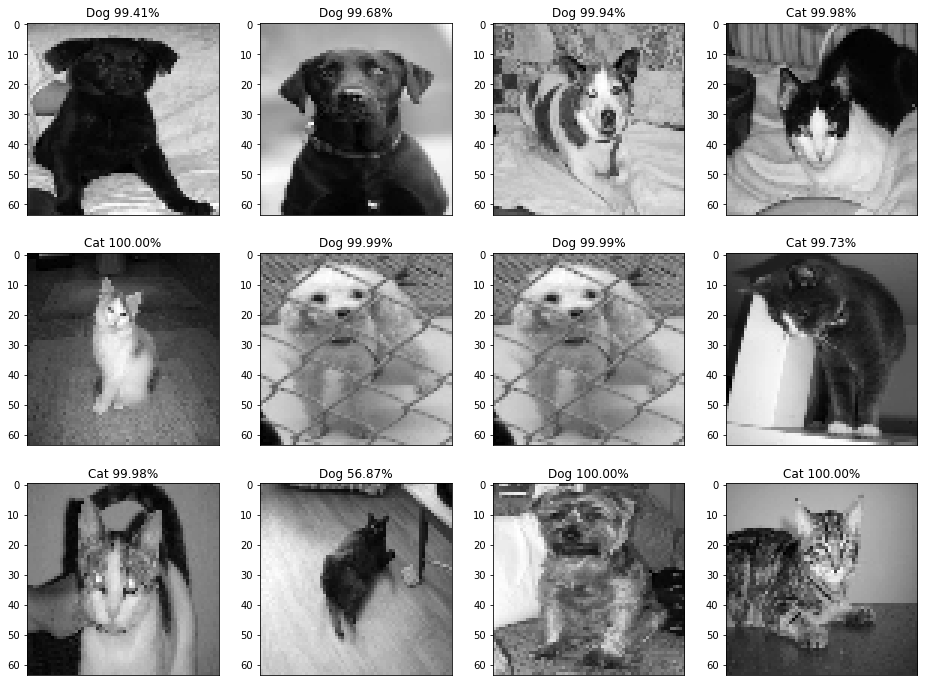

In [154]:
fig = plt.figure(figsize=(16, 12))
for num, data in enumerate(test_data[np.random.choice(range(0, 12500), 12)], 1):
    img_num = data[1]
    img_data = data[0]
    
    subplot = fig.add_subplot(3, 4, num)
    img = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    predict = model.predict([img])[0]
    
    if np.argmax(predict) == 1:
        label = "Dog {:.2f}%".format(float(max(predict)) * 100)
    else:
        label = "Cat {:.2f}%".format(float(max(predict)) * 100)
        
    subplot.imshow(img_data, cmap="gray")
    plt.title(label)
    subplot.axes.get_xaxis().set_visible(False)
    subplot.axes.get_xaxis().set_visible(False)
plt.show();

## Make submission file

In [155]:
with open("submission_3.csv", "w") as fp:
    fp.write("id,label\n")
    string = ""
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        img = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        model_out = model.predict([img])[0]
        string += "{},{}\n".format(img_num, model_out[1])
    fp.write(string)

9

100%|████████████████████████████████| 12500/12500 [00:25<00:00, 484.79it/s]


314686